### Take a stab at implementing GLMs 
With params: 
- RPE
- Features
- RPE and Features interaction terms

Find units that significantly improve with the inclusion variance explained with interaction terms, either:
- Before or during selection
- during feedback

Results are: 
- Per unit per time, Fraction of deviance explained. 
- For each model, per unit per time, weights
- corresponding shuffles

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.behavioral_utils as behavioral_utils
from sklearn.linear_model import PoissonRegressor

from models.trainer import Trainer
from models.model_wrapper import ModelWrapperRegression
from models.multinomial_logistic_regressor import MultinomialLogisticRegressor
from torch.nn import PoissonNLLLoss

import os
import pandas as pd
import matplotlib
import itertools

In [2]:
sess_name = 20180802

FEATURE_DIMS = ["Color", "Shape", "Pattern"]
OUTPUT_DIR = "/data/patrick_res/information"

SESSIONS_PATH = "/data/patrick_res/multi_sess/valid_sessions_rpe.pickle"
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"

PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "FeedbackOnset"
fr_path = f"/data/patrick_res/multi_sess/{sess_name}/{sess_name}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"

POSSIBLE_RPE_GROUPS = ["more_neg", "less_neg", "less_pos", "more_pos"]
POSSIBLE_FEATURES = [
    'CIRCLE', 'SQUARE', 'STAR', 'TRIANGLE', 
    'CYAN', 'GREEN', 'MAGENTA', 'YELLOW', 
    'ESCHER', 'POLKADOT', 'RIPPLE', 'SWIRL'
]
POSSIBLE_INTERACTIONS = [f"{feat}_{rpe}" for feat, rpe in itertools.product(POSSIBLE_FEATURES, POSSIBLE_RPE_GROUPS)]


In [3]:
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=sess_name)
beh = pd.read_csv(behavior_path)
frs = pd.read_pickle(fr_path)

# filter trials 
valid_beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber")
valid_beh_rpes = behavioral_utils.get_rpes_per_session(sess_name, valid_beh)

neg_med = valid_beh_rpes[valid_beh_rpes.RPE_FE < 0].RPE_FE.median()
pos_med = valid_beh_rpes[valid_beh_rpes.RPE_FE > 0].RPE_FE.median()

# add median labels to 
def add_group(row):
    rpe = row.RPE_FE
    group = None
    if rpe < neg_med:
        group = "more_neg"
    elif rpe >= neg_med and rpe < 0:
        group = "less_neg"
    elif rpe >= 0 and rpe < pos_med:
        group = "less_pos"
    elif rpe > pos_med:
        group = "more_pos"
    row["RPEGroup"] = group
    return row
valid_beh = valid_beh_rpes.apply(add_group, axis=1)
for feature_dim in FEATURE_DIMS:
    valid_beh[f"{feature_dim}RPE"] = valid_beh[feature_dim] + "_" + valid_beh["RPEGroup"]

valid_beh = valid_beh.set_index("TrialNumber")
frs = frs.set_index("TrialNumber")

In [5]:
unit = 9
unit_frs = frs[frs.UnitID == unit]

In [6]:
def flatten_columns(beh, columns):
    flattened_columns = []
    for column in columns:
        values = beh[column].unique()
        for value in values:
            beh[value] = (beh[column] == value).astype(int)
        flattened_columns.extend(values)
    return beh, flattened_columns

def fit_glm(df, x_cols, y_col):
    ys = df[y_col].values
    xs = df[x_cols].values
    model = PoissonRegressor(alpha=1)
    model = model.fit(xs, ys)
    return pd.Series({"score": model.score(xs, ys)})

def fit_glm_torch(df, x_cols, y_col):
    ys = df[y_col].values
    xs = df[x_cols].values
    init_params = {"n_inputs": xs.shape[1], "n_classes": 1}
    # create a trainer object
    trainer = Trainer(
        learning_rate=0.05, 
        max_iter=500, 
        loss_fn=PoissonNLLLoss(log_input=True),
        weight_decay=1
    )
    # create a wrapper for the decoder
    model = ModelWrapperRegression(MultinomialLogisticRegressor, init_params, trainer)
    model = model.fit(xs, ys)
    return pd.Series({"score": model.score(xs, ys)})


def fit_glms_by_time(data, x_inputs):
    data, flattened_columns = flatten_columns(data, x_inputs)
    res = data.groupby("TimeBins").apply(lambda x: fit_glm(x, flattened_columns, "SpikeCounts")).reset_index()
    # res = data.groupby("TimeBins").apply(lambda x: fit_glm_torch(x, flattened_columns, "SpikeCounts")).reset_index()
    return res.fillna(0)

def create_shuffles(data, columns, rng):
    for column in columns:
        vals = data[column].values
        rng.shuffle(vals)
        data[column] = vals
    return data

def fit_n_shuffles(beh, frs, input_columns, shuffle_columns, num_shuffles):
    rng = np.random.default_rng()
    shuffled_reses = []
    shuffle_beh = beh.copy()
    beh_inputs_to_shuffle = shuffle_beh[input_columns]
    for i in range(num_shuffles):
        shuffled_inputs = create_shuffles(beh_inputs_to_shuffle, shuffle_columns, rng)
        shuffled_data = pd.merge(shuffled_inputs, frs, on="TrialNumber")
        shuffled_res = fit_glms_by_time(shuffled_data, input_columns)
        shuffled_res["ShuffledIdx"] = i
        shuffled_reses.append(shuffled_res)
    shuffled = pd.concat(shuffled_reses)
    return shuffled

### RPE Only

In [7]:
input_columns = ["RPEGroup"]
beh_inputs = valid_beh[input_columns]
data = pd.merge(beh_inputs, unit_frs, on="TrialNumber")
rpe_res = fit_glms_by_time(data, input_columns)

/usr/local/lib/python3.10/dist-packages/sklearn/_loss/link.py:172: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/usr/local/lib/python3.10/dist-packages/sklearn/_loss/link.py:172: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)


In [12]:
shuffled = fit_n_shuffles(
    valid_beh, 
    unit_frs, 
    input_columns=input_columns, 
    shuffle_columns=input_columns,
    num_shuffles=5
)
shuffled_max = shuffled.groupby("TimeBins").max()

/tmp/ipykernel_27320/4174747178.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = vals
/tmp/ipykernel_27320/4174747178.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = vals
/tmp/ipykernel_27320/4174747178.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

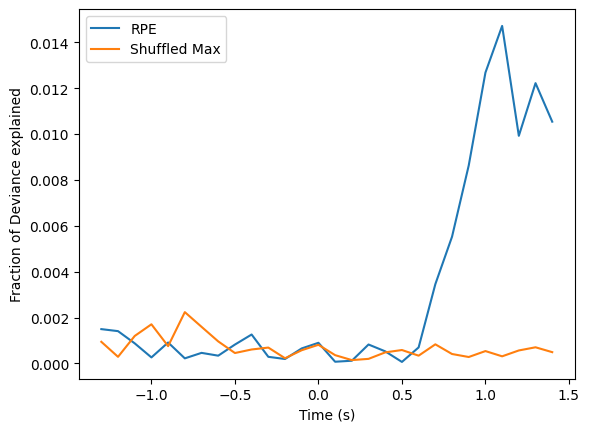

In [13]:
fig, ax = plt.subplots()
time_bins = rpe_res.TimeBins - 1.3
ax.plot(time_bins, rpe_res.score, label="RPE")
ax.plot(time_bins, shuffled_max.score, label="Shuffled Max")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Fraction of Deviance explained")
ax.legend()

### RPE + Features

In [8]:
input_columns = ["RPEGroup"] + FEATURE_DIMS
beh_inputs = valid_beh[input_columns]
data = pd.merge(beh_inputs, unit_frs, on="TrialNumber")
rpe_features_res = fit_glms_by_time(data, input_columns)

/usr/local/lib/python3.10/dist-packages/sklearn/_loss/link.py:172: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/usr/local/lib/python3.10/dist-packages/sklearn/_loss/link.py:172: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)


In [15]:
rpe_features_shuffled = fit_n_shuffles(
    valid_beh, 
    unit_frs, 
    input_columns=input_columns, 
    shuffle_columns=FEATURE_DIMS,
    num_shuffles=5
)

/tmp/ipykernel_27320/4174747178.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = vals
/tmp/ipykernel_27320/4174747178.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = vals
/tmp/ipykernel_27320/4174747178.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [16]:
rpe_features_shuffled_max = rpe_features_shuffled.groupby("TimeBins").max()

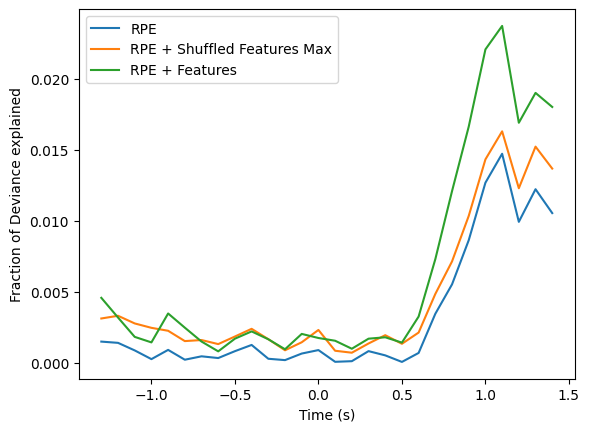

In [17]:
fig, ax = plt.subplots()
time_bins = rpe_res.TimeBins - 1.3
ax.plot(time_bins, rpe_res.score, label="RPE")
ax.plot(time_bins, rpe_features_shuffled_max.score, label="RPE + Shuffled Features Max")
ax.plot(time_bins, rpe_features_res.score, label="RPE + Features")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Fraction of Deviance explained")
ax.legend()

### RPE + Features + Interactions

In [9]:
INTERACTIONS = [f"{dim}RPE" for dim in FEATURE_DIMS]

In [10]:
input_columns = ["RPEGroup"] + FEATURE_DIMS + INTERACTIONS
beh_inputs = valid_beh[input_columns]
data = pd.merge(beh_inputs, unit_frs, on="TrialNumber")
interactions_res = fit_glms_by_time(data, input_columns)

/usr/local/lib/python3.10/dist-packages/sklearn/_loss/link.py:172: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/usr/local/lib/python3.10/dist-packages/sklearn/_loss/link.py:172: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)


In [11]:
interactions_shuffled = fit_n_shuffles(
    valid_beh, 
    unit_frs, 
    input_columns=input_columns, 
    shuffle_columns=INTERACTIONS,
    num_shuffles=5
)

/tmp/ipykernel_42062/4174747178.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = vals
/usr/local/lib/python3.10/dist-packages/sklearn/_loss/link.py:172: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/usr/local/lib/python3.10/dist-packages/sklearn/_loss/link.py:172: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/tmp/ipykernel_42062/4174747178.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = vals
/u

In [12]:
interactions_shuffled_max = interactions_shuffled.groupby("TimeBins").max()

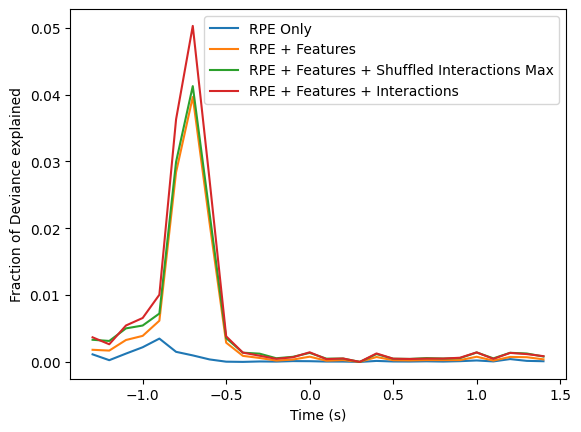

In [13]:
fig, ax = plt.subplots()
time_bins = rpe_res.TimeBins - 1.3
ax.plot(time_bins, rpe_res.score, label="RPE Only")
ax.plot(time_bins, rpe_features_res.score, label="RPE + Features")
ax.plot(time_bins, interactions_shuffled_max.score, label="RPE + Features + Shuffled Interactions Max")
ax.plot(time_bins, interactions_res.score, label="RPE + Features + Interactions")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Fraction of Deviance explained")
ax.legend()